In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 0. Functions

In [33]:
def like_calc(y_sim, y_mes, std):
    like = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return like

def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [5]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'5% Median: {med1} \n Stats: {stat1} \n')
    print(f'10% Median: {med2} \n Stats: {stat2} \n')
    print(f'15% Median: {med3} \n Stats: {stat3} \n')
    print(f'20% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    means = [stat1.mean, stat2.mean, stat3.mean, stat4.mean]
    return meds, maxs, means

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'BWR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [35]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Likelihood', fontsize=14, labelpad=15)
        #ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [36]:
pklfile = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [37]:
ratios = XY.loc[:, lbls].copy()

In [38]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)

In [40]:
ratios.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
19066,bwr,0.392519,1.91,3244.15,atrium10x10-9,0.994825,0.010158,0.302568,0.001843,16.155225,8.187283,0.051336,0.073514,0.011165,0.000347
19093,bwr,0.392519,1.91,7598.62,atrium10x10-9,0.966942,0.024487,0.303039,0.003590,36.638734,19.320298,0.090780,0.153731,0.052149,0.004171
23948,pwr,0.951624,4.38,28639.85,vver440_4.38,1.039060,0.099651,0.362098,0.014208,78.796047,28.068284,0.212643,0.221455,0.328935,0.104028
22436,bwr,0.507270,3.28,55458.06,svea100-0,1.155270,0.134610,0.321797,0.023188,283.482143,85.723214,0.201298,0.314605,0.373386,0.415450
13271,bwr,0.000000,2.09,11688.77,ge9x9-2,0.966737,0.034594,0.290670,0.004831,65.029082,33.973826,0.108768,0.233972,0.104355,0.014643
17919,bwr,0.710696,2.94,13523.12,atrium9x9-9,0.970243,0.042911,0.303202,0.005869,64.956522,32.130435,0.122673,0.238943,0.138792,0.022400
20214,bwr,0.961568,0.50,41407.54,svea64-1,1.067121,0.104923,0.236098,0.014648,301.630069,130.230365,0.157040,0.536670,0.338447,0.437044
14380,bwr,2929.827633,0.50,51452.75,ge10x10-8,0.939343,0.010359,0.380717,0.021347,174.472050,60.981366,0.091987,0.409287,0.229123,0.481649
10520,bwr,24.504738,2.89,2024.53,ge7x7-0,0.930010,0.006076,0.308129,0.001634,7.051522,3.321624,0.034398,0.048040,0.004871,0.000095
20492,bwr,0.000641,1.36,59693.38,svea64-1,1.188417,0.133853,0.268876,0.023404,486.524823,169.739953,0.175402,0.442751,0.361475,0.640514


## (a) Get test sample for LL calcs

In [43]:
# Choosing PWR sample intentionally
sim_idx = 10522
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
10522,bwr,2421.282899,2.89,2024.53,ge7x7-0


In [44]:
ratios.drop(10522, inplace=True)

## (b) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [45]:
fullXY = ratios.loc[ratios['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [46]:
uncs = [0.05, 0.10, 0.15, 0.20] 
for unc in uncs:
    like_name = 'Likelihood' + str(unc)
    fullXY[like_name] = X.apply(lambda row: like_calc(row, test_sample.iloc[0], unc*row), axis=1)
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    fullXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [32]:
#fullXY.to_csv('likelihood_idx10522_10ratios_opusupdate-aug2019.csv')
# 10522 or 5010
fullXY = pd.read_csv('likelihood_idx10522_10ratios_opusupdate-aug2019.csv')
fullXY.head()

,Unnamed: 0,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,pwr,0.000839,0.53,2006.54,ce14x14,1.093932,0.004286,0.211022,0.000971,...,66.615974,2.780140e-52,-118.711923,33.307987,2.887435e-14,-31.175823,22.205325,0.135894,-1.995880,16.653994
1,2,pwr,0.592485,0.53,2006.54,ce14x14,1.080899,0.004286,0.214933,0.000982,...,66.098521,1.742206e-49,-112.271517,33.049261,5.815607e-13,-28.173061,22.032840,0.821771,-0.196294,16.524630
2,3,pwr,1.109213,0.53,2006.54,ce14x14,1.070205,0.004284,0.217600,0.000992,...,65.794747,8.832344e-48,-108.345664,32.897374,3.661534e-12,-26.333139,21.931582,2.493163,0.913552,16.448687
3,4,pwr,8.460400,0.53,2006.54,ce14x14,0.976211,0.004258,0.220206,0.001114,...,66.115650,5.011443e-44,-99.702020,33.057825,2.622719e-10,-22.061639,22.038550,38.659829,3.654801,16.528913
4,5,pwr,38.415629,0.53,2006.54,ce14x14,0.924535,0.004151,0.220638,0.001318,...,64.243267,1.006477e-39,-89.794363,32.121634,2.142689e-08,-17.658619,21.414422,459.986926,6.131198,16.060817


# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [33]:
l0 = 'Likelihood0.05'
l1 = 'Likelihood0.1'
l2 = 'Likelihood0.15'
l3 = 'Likelihood0.2'
zname = [l0, l1, l2, l3]
uncss = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [34]:
meds, maxs, means = getstats_unc(fullXY, l0, l1, l2, l3)

5% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 4.791696762138483e+20), mean=2.773053307711537e+16, variance=1.0531532104577889e+37, skewness=136.3849465184855, kurtosis=19566.602266007365) 

10% Median: 7.463723260417388e-138 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 6.734910682236007e+19), mean=8828200420203270.0, variance=3.8735608058436225e+35, skewness=90.26022228380769, kurtosis=8601.494104737654) 

15% Median: 4.182109236949011e-58 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 2.931401212033838e+18), mean=882124611266717.0, variance=1.3540672787783822e+33, skewness=61.8752961398601, kurtosis=4414.608950776339) 

20% Median: 8.143683301356037e-31 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 2.5887385322904896e+17), mean=129175231602726.39, variance=1.5867597245102776e+31, skewness=41.63239868969461, kurtosis=2015.7622743065374) 



In [35]:
plotXY = fullXY

In [41]:
x10522 = 2024
y10522 = 2421
x10522_pred = [1964, 1964, 1964, 1964]
y10522_pred = [2503, 2503, 2503, 2503]
x5010 = 39383
y5010 = 306
x5010_pred = [39013, 37162, 37162, 37162]
y5010_pred = [343, 306, 306, 306]

<Figure size 432x288 with 0 Axes>

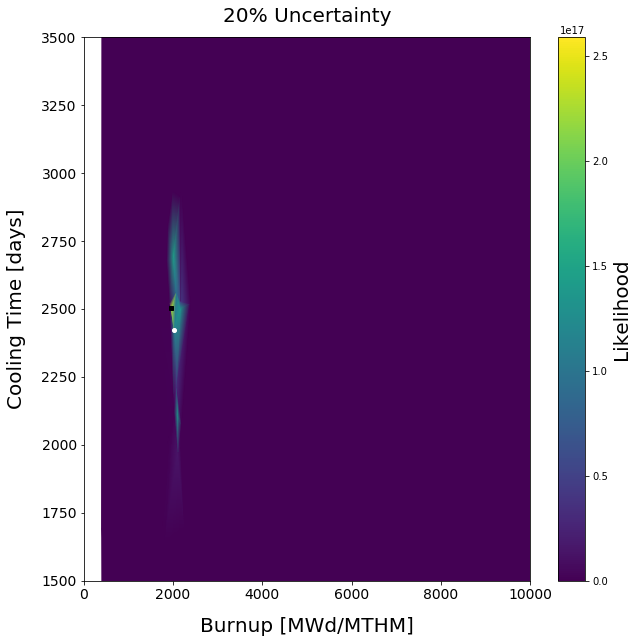

In [45]:
plt.clf()

vmin=0#meds[0]
vmax=maxs[3]

fig = plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111)
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)

z = plotXY[l3]
ax.set_title(uncss[3], fontsize=20, pad=15)

surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
plt.plot([x10522], [y10522], marker='o', markersize=4, color="white")
plt.plot([x10522_pred[3]], [y10522_pred[3]], marker='s', markersize=4, color="black")

ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_xlim(0, 10000)#(30000, 50000)#
ax.set_ylim(1500, 3500)#(0, 2500)#

cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('Likelihood', size=20)
ax.tick_params(labelsize=14)
plt.show()

fig.savefig('../plots/llsurf_idx10522_0.20unc_ratios.png', bbox_inches='tight', transparent=True)

# 3. Get LL Pred Results

In [36]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [37]:
fullXY.head()

,Unnamed: 0,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,pwr,0.000839,0.53,2006.54,ce14x14,1.093932,0.004286,0.211022,0.000971,...,66.615974,2.780140e-52,-118.711923,33.307987,2.887435e-14,-31.175823,22.205325,0.135894,-1.995880,16.653994
1,2,pwr,0.592485,0.53,2006.54,ce14x14,1.080899,0.004286,0.214933,0.000982,...,66.098521,1.742206e-49,-112.271517,33.049261,5.815607e-13,-28.173061,22.032840,0.821771,-0.196294,16.524630
2,3,pwr,1.109213,0.53,2006.54,ce14x14,1.070205,0.004284,0.217600,0.000992,...,65.794747,8.832344e-48,-108.345664,32.897374,3.661534e-12,-26.333139,21.931582,2.493163,0.913552,16.448687
3,4,pwr,8.460400,0.53,2006.54,ce14x14,0.976211,0.004258,0.220206,0.001114,...,66.115650,5.011443e-44,-99.702020,33.057825,2.622719e-10,-22.061639,22.038550,38.659829,3.654801,16.528913
4,5,pwr,38.415629,0.53,2006.54,ce14x14,0.924535,0.004151,0.220638,0.001318,...,64.243267,1.006477e-39,-89.794363,32.121634,2.142689e-08,-17.658619,21.414422,459.986926,6.131198,16.060817


## Reactor Prediction

In [38]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,44.953178,6.678319,45.225612,3.339159,42.505018,2.226106,40.095117,1.669580
bwr,47.618586,5.268970,45.656421,2.634485,42.522012,1.756323,39.967276,1.317243
phwr,-120.450201,22.985356,2.483839,11.492678,22.478356,7.661785,28.018745,5.746339


In [39]:
idx

{'LogLikelihood_0.05': [22847, 20912, 24242],
 'LogLikelihood_0.1': [22847, 20912, 24242],
 'LogLikelihood_0.15': [22847, 20912, 24242],
 'LogLikelihood_0.2': [22847, 20912, 24242]}

In [40]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup', 'CoolingTime']])

LogLikelihood_0.05
      ReactorType   Burnup  CoolingTime
22847         pwr  2171.75   2528.16269
      ReactorType   Burnup  CoolingTime
20912         bwr  1963.55  2503.299058
      ReactorType   Burnup  CoolingTime
24242        phwr  3308.69  2519.487975
LogLikelihood_0.1
      ReactorType   Burnup  CoolingTime
22847         pwr  2171.75   2528.16269
      ReactorType   Burnup  CoolingTime
20912         bwr  1963.55  2503.299058
      ReactorType   Burnup  CoolingTime
24242        phwr  3308.69  2519.487975
LogLikelihood_0.15
      ReactorType   Burnup  CoolingTime
22847         pwr  2171.75   2528.16269
      ReactorType   Burnup  CoolingTime
20912         bwr  1963.55  2503.299058
      ReactorType   Burnup  CoolingTime
24242        phwr  3308.69  2519.487975
LogLikelihood_0.2
      ReactorType   Burnup  CoolingTime
22847         pwr  2171.75   2528.16269
      ReactorType   Burnup  CoolingTime
20912         bwr  1963.55  2503.299058
      ReactorType   Burnup  CoolingTime
24242 